In [32]:
!pip install numpy pandas seaborn matplotlib scikit-learn imbalanced-learn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/d8/0d/c3bfccc5d460eec8ff56889802aa88f5d07280d5282b307a74558e6edc44/imbalanced_learn-0.12.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.3 kB ? eta -:--:--
   --------- ----------------------------- 61.4/258.3 kB 656.4 kB/s eta 0:00:01
   ------------------------- -------------- 163.8/258.3 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------  256.0/258.3 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 1.4 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [8]:
# Ensure plots are visible within the Jupyter Notebook
%matplotlib inline

# Check if mother_dataset.csv already exists
if os.path.exists("mother_dataset.csv"):
    # If exists, load the dataset from the CSV file
    mother_dataset = pd.read_csv("mother_dataset.csv")
else:
    # List of file paths for each quarterly dataset
    file_paths = [
        'INFOTABLE_2023q4.tsv'
    ]

    # Initialize an empty list to hold dataframes
    dataframes = []

    # Process each file
    for file_path in file_paths:
        # Extract year and quarter from the filename
        year_quarter = file_path.split('_')[1].split('.')[0]
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4:].replace("q", ""))  # Remove lowercase "q"

        # Load the data
        df = pd.read_csv(file_path, delimiter='\t')

        # Rename ACCESSION_NUMBER to investor
        df.rename(columns={'ACCESSION_NUMBER': 'investor'}, inplace=True)

        # Add a timestamp column at the start date of the quarter
        if quarter == 1:
            df['timestamp'] = pd.Timestamp(year, 1, 1)  # Q1: January 1st
        elif quarter == 2:
            df['timestamp'] = pd.Timestamp(year, 4, 1)  # Q2: April 1st
        elif quarter == 3:
            df['timestamp'] = pd.Timestamp(year, 7, 1)  # Q3: July 1st
        elif quarter == 4:
            df['timestamp'] = pd.Timestamp(year, 10, 1)  # Q4: October 1st

        # Append the processed dataframe to the list
        dataframes.append(df)

    # Concatenate all dataframes into a single "mother_dataset"
    mother_dataset = pd.concat(dataframes, ignore_index=True)

    # Save the mother_dataset to a CSV file for future use
    mother_dataset.to_csv("mother_dataset.csv", index=False)
    
# Display the first few rows to confirm
print(mother_dataset.head())

C:\Users\Aditya Saxena\AppData\Local\Temp\ipykernel_12312\2349068421.py:7: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  mother_dataset = pd.read_csv("mother_dataset.csv")


               investor  INFOTABLE_SK                NAMEOFISSUER  \
0  0000051762-23-000005      94734396         ABBOTT LABORATORIES   
1  0000051762-23-000005      94734397                  ABBVIE INC   
2  0000051762-23-000005      94734398                   ADOBE INC   
3  0000051762-23-000005      94734399  ADVANCED MICRO DEVICES INC   
4  0000051762-23-000005      94734400             AES CORPORATION   

  TITLEOFCLASS      CUSIP          FIGI     VALUE  SSHPRNAMT SSHPRNAMTTYPE  \
0          COM  002824100  BBG00KTDT9Q6   1515058      15643            SH   
1          COM  00287Y109  BBG00KTDTBZ1  57330720     384615            SH   
2          COM  00724F101  BBG00GQ6RYG1   8060499      15808            SH   
3          COM  007903107  BBG00KTDTC25   2301934      22388            SH   
4          COM  00130H105  BBG00J9TZDP1    153596      10105            SH   

  PUTCALL INVESTMENTDISCRETION OTHERMANAGER  VOTING_AUTH_SOLE  \
0     NaN                 SOLE          NaN        

In [9]:
# Display dataset structure and sample rows
print(mother_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2886468 entries, 0 to 2886467
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   investor              object
 1   INFOTABLE_SK          int64 
 2   NAMEOFISSUER          object
 3   TITLEOFCLASS          object
 4   CUSIP                 object
 5   FIGI                  object
 6   VALUE                 int64 
 7   SSHPRNAMT             int64 
 8   SSHPRNAMTTYPE         object
 9   PUTCALL               object
 10  INVESTMENTDISCRETION  object
 11  OTHERMANAGER          object
 12  VOTING_AUTH_SOLE      int64 
 13  VOTING_AUTH_SHARED    int64 
 14  VOTING_AUTH_NONE      int64 
 15  timestamp             object
dtypes: int64(6), object(10)
memory usage: 352.4+ MB
None


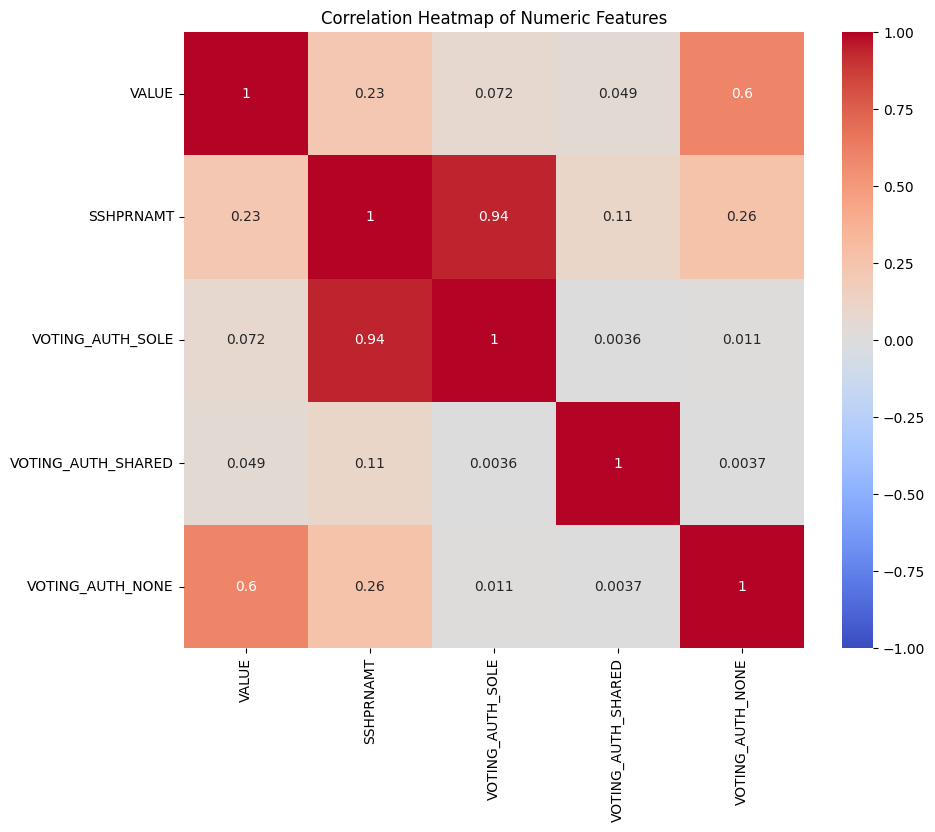

In [10]:
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

plt.figure(figsize=(10, 8))
sns.heatmap(mother_dataset[numeric_features].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


### Data Scaling and Its Importance

**Data Scaling** is a critical preprocessing step in improving model performance and avoiding bias in machine learning tasks. In our project, we have features with varying ranges, and without scaling, features with larger scales could disproportionately influence the model. 

Our dataset includes features with varying numeric ranges (e.g., `VALUE`, `SSHPRNAMT`, and `VOTING_AUTH_*` columns). Without scaling, these features with larger values could overshadow features with smaller values, potentially skewing the results. This disparity could also hinder model convergence and reduce the effectiveness of model training.

To address these scaling differences, we have chosen **Standardization** as our primary technique, which centers data by subtracting the mean and dividing by the standard deviation. Standardization is especially suitable for datasets with normally distributed features, helping the model process all features on a comparable scale.

This could result in skewed analysis and inaccurate conclusions. Hence, it is essential to apply scaling techniques such as **Standardization** to bring all numeric features to a comparable scale, which ensures fair weighting across features and enhances interpretability.

In our dataset, we will focus on scaling the following numeric features:
- `VALUE`
- `SSHPRNAMT`
- `VOTING_AUTH_SOLE`
- `VOTING_AUTH_SHARED`
- `VOTING_AUTH_NONE`

We plan to approach scaling differently based on whether we are using **Time Series Cross-Validation** or not.

### Scaling Without Time Series Cross-Validation

Since we currently only have data for one quarter, there is no temporal pattern or chronological dependency to consider. This allows us to perform **Standardization** (Z-score scaling) across the entire dataset for this quarter without introducing bias from future data. Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, making the scale of all features comparable.

In [11]:
# List of numeric features to scale
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to the numeric features
mother_dataset_standardized = mother_dataset.copy()
mother_dataset_standardized[numeric_features] = scaler.fit_transform(mother_dataset[numeric_features])

# Display standardized data for verification
print(mother_dataset_standardized[numeric_features].head())

      VALUE  SSHPRNAMT  VOTING_AUTH_SOLE  VOTING_AUTH_SHARED  VOTING_AUTH_NONE
0 -0.037204  -0.030747         -0.020773           -0.023223         -0.033427
1  0.102095   0.007433          0.016028           -0.023223         -0.024865
2 -0.020869  -0.030730         -0.020840           -0.023223         -0.033099
3 -0.035241  -0.030049         -0.020258           -0.023223         -0.032656
4 -0.040602  -0.031320         -0.021486           -0.023223         -0.032929


### Scaling With Time Series Cross-Validation

As we move to the next milestone, we plan to add multiple quarters over 5+ years to create a comprehensive dataset with chronological data. When using this data for **Time Series Cross-Validation**, we must account for the temporal order to avoid data leakage, where future information might inadvertently influence the past. If we apply a global scaling approach across the whole dataset, it would incorporate information from future quarters, leading to optimistic results and bias.

To avoid this, we will apply **Standardization separately in each fold** of the cross-validation process. By standardizing data independently within each training fold, we ensure that each fold remains isolated from future information, preserving the temporal structure and yielding a more accurate evaluation.

In other words, as we expand to **multiple quarters in the next milestone**, applying global scaling across the dataset would cause **data leakage**, where future data influences past data, resulting in optimistic bias and unreliable evaluations. Instead, we will implement Standardization separately within each fold of the cross-validation process. This approach isolates the training and test data in each fold, ensuring future data does not impact past observations.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

for train_index, test_index in tscv.split(mother_dataset):
    train_data, test_data = mother_dataset.iloc[train_index], mother_dataset.iloc[test_index]
    
    # Standardize within the training fold only
    scaler = StandardScaler()
    train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
    
    # Apply the same transformation to the test fold without fitting again
    test_data[numeric_features] = scaler.transform(test_data[numeric_features])
    
    # Use train_data and test_data in the model training and evaluation